# Data science in Neuroscience


## Plan for today

1. Review of last week's exercises
2. Why and how are in-vivo recordings performed?
3. Extracting action potentials from raw signals
    * Filtering
    * Detecting spikes
    * Extracting spike waveforms
    * Dimensionality reduction
    * Clustering spike waveforms

***

## Review of last week's exercises

Reload the data from last week.

The is a recording from 8 electrodes/channels for 1 second at 20 000 Hz.


In [5]:
import numpy as np
import matplotlib.pyplot as plt

fileName = "../data/shortRaw.npy" # binder users or people with a local git repository
dat = np.load(fileName)

* What do you think the electrodes are measuring? 
* How many dimensions does the data have?
* What is the size of the array in each dimension?
* What is the data type or dtype (integer, float, etc.) of the `dat` array?
* Which dimension represents the recording channels and the recording samples?

In [6]:
print("ndim:",dat.ndim)
print("shape:",dat.shape)
print("dtype:",dat.dtype)

ndim: 2
shape: (8, 20000)
dtype: int16


From this information, we know that the array looks like on this figure.
<div>
<img src="../images/array.png" width="600"/>
</div>




* Plot the data for the first recording channel.
* Do you seen any oscillatory patterns in the data? If so at which frequency? 
* Plot the data for 2 recording channels. 
* What is similar or different between the different channels?

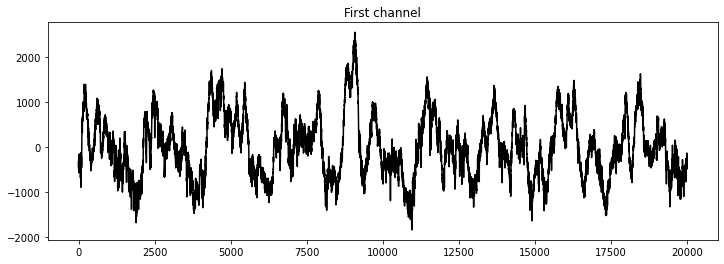

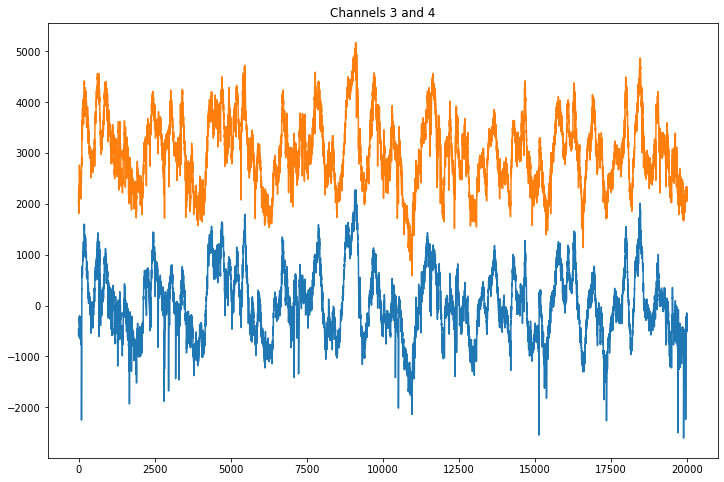

In [177]:
# plot the first channel
plt.figure(figsize=(12,4))
plt.plot(dat[0,:],c="black")
plt.title("First channel")
plt.show()

# plot 2 channels
plt.figure(figsize=(12,8))
plt.plot(dat[3,:])
plt.plot(dat[4,:]+3000) # I added 3000 to the values of channel 4 to be able to see it.
plt.title("Channels 3 and 4")
plt.show()

* What is the mean value in the `dat` array?
* What is the mean value per channel of the `dat` array?
* Can you plot the mean value across channels for all samples? The plot should have 20000 values.
* How could I add 100 to all values in the array?
* Which channel has the largest standard deviation?
* Can you plot the distribution of values for the second recording channel?
* For each channel, remove the mean from every data point.


In [7]:
print("The mean of dat is :",dat.mean())
print("Mean per channel:")
print(dat.mean(axis=1))

The mean of dat is : 3.06385
Mean per channel:
[ -9.30035  18.965   -14.9138   28.8605   16.56955  29.91675 -33.8044
 -11.78245]


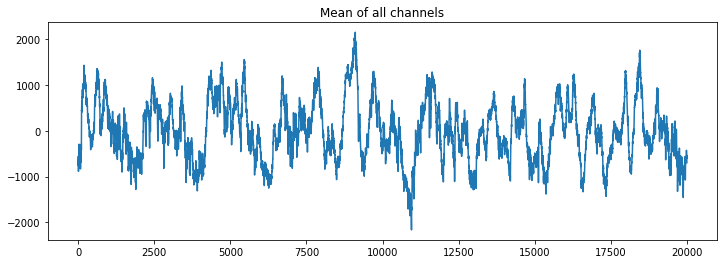

In [8]:
plt.figure(figsize=(12,4))
plt.plot(dat.mean(axis=0))
plt.title("Mean of all channels")
plt.show()

In [9]:
dat+100
print("Standard deviation per channel:")
print(dat.std(axis=1))
      
print("Channel with the largest standard deviation")
print(np.argmax(dat.std(axis=1))) # note the use of np.argmax()

Standard deviation per channel:
[676.37638925 676.71487369 682.68302745 669.85032936 688.10030647
 641.68837049 673.63273573 651.19369954]
Channel with the largest standard deviation
4


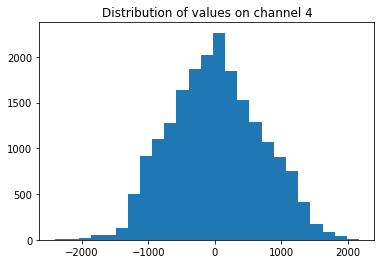

In [10]:
plt.hist(dat[4,:],bins=25)
plt.title("Distribution of values on channel 4")
plt.show()

***

# Why and how are in-vivo recordings performed?

**Aim:** Monitor the activity of groups of neurons during behavior. 

The correlations between cell activity and behavior informs us about the potential role of a brain area for behavior. We can learn how information is processed within neuronal circuits. The effect of different manipulations (optogenetics, pharmacology) on network activity can be assessed.

## Example: Spatially selective neurons in the medial entorhinal cortex (MEC)

By recording the activity of neurons in the entorhinal cortex in freely-moving mice, scientists discovered that MEC neurons encode where the animal is in its environment and in which direction it is heading. This brain region is essential for navigation.


<div>
<img src="../images/mec_neurons.png" width="400"/>
</div>

* Right column: Spikes (red) on top of the path of the animal (black).
* Left column: Firing rate of the neuron as a function of position (top), head-direction (middle) and running speed (bottom). 


### References
* Hafting et al., 2005. Microstructure of a spatial map in the entorhinal cortex. Nature
* Sargolini et al., 2006. Conjunctive Representation of Position, Direction, and Velocity in Entorhinal Cortex. Nature
* Gil et al., 2018. Impaired path integration in mice with disrupted grid cell firing. Nature Neuroscience

## Electrodes -> Amplifier -> Digitalization -> Recording on disk

Electrodes located in the extracellular space can pick up action potentials (sharp negative fluctuation in voltage) from several neurons. 

<div>
<img src="../images/buzsaki_tetrode_in_layer.jpg" width="600"/>
</div>


<div>
<img src="../images/buzsaki_probe.webp" width="800"/>
</div>

<div>
<img src="../images/intan_64.jpg" width="300"/>
</div>


### References
* Buzsaki, 2004. Large-scale recording of neuronal ensembles. Nature Neuroscience
* Steinmetz et al., 2021. Neuropixels 2.0: A miniaturized high-density probe for stable, long-term brain recordings. Science
* https://intantech.com/


The recording system sample the voltage on multiple channels at 20-30 kHz. The amplified signal is saved to disk for later analysis.

***

# Spike extraction and clustering

We want to study the activity (action potentials) of single neurons. We need to find at which time which neuron fired action potentials. 

One assumption is that the all spikes from one neuron will have a constant waveform on the different channels. The pattern across the different channels depend on the proximity of the neuron to the different electrodes (channels).

Let's have a look at our data.

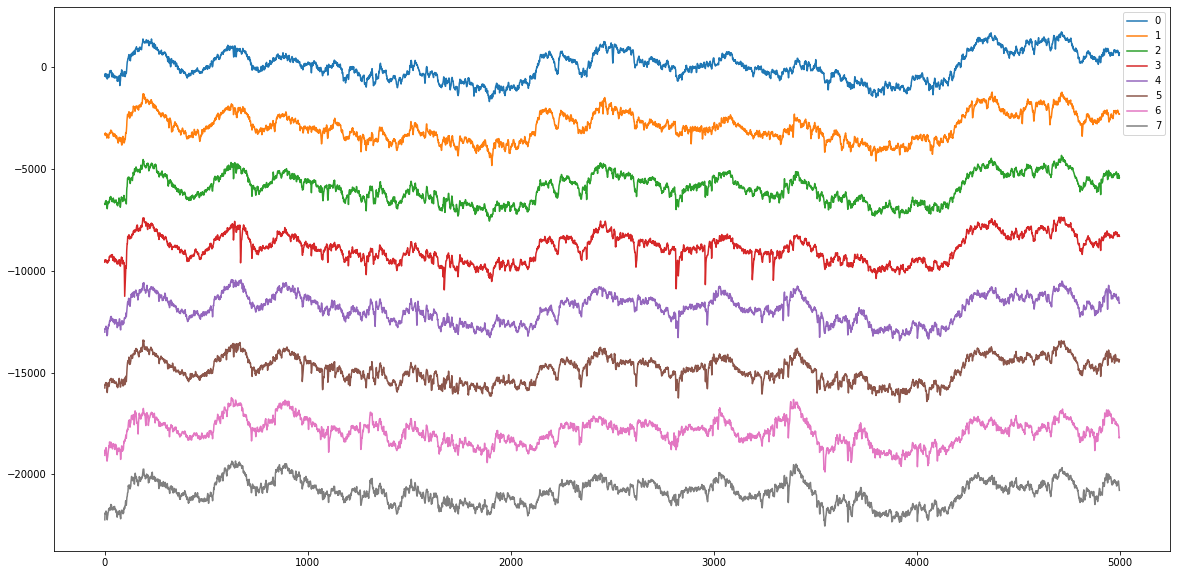

In [116]:
offset=3000 #y-shift between channels when plotting the data
nSamples=5000
plt.figure(figsize=(20,10)) # set the size of the figure

for i in range(dat.shape[0]): #loop for every channel
    plt.plot(dat[i,:nSamples]-i*3000,label=i) # plot the channel, apply the y-offset so that the channels are not all on top of each other
plt.legend()
plt.show()

## Steps involved
* Filtering
* Identifying spikes
* Extracting spike waveforms
* Dimensionality reduction
* Clustering spike waveforms

Note: In the lab, you would normally use an established software package to do this (Kilosort, Spyking circus, etc.).

Many classic data processing steps are involved.

*** 
## Filtering

The signal recorded is the sum of several components: 

1. Large amplitude spikes of a few neurons close to the recording sites
2. Small amplitude spikes of many distant neurons
3. Fluctuations in synaptic currents onto thousands of neurons
4. Electrical noise 
5. Head muscle contractions (e.g., noise associated with chewing)
6. Motion artifacts

If a neuron is close enough to our electrodes, its action potentials create rapid (usually) negative deflections in the signal. The spikes in extracellular space last less than 1 ms.

To extract action potentials, we need to separate these fast negative deflections from other slower components of the signal. That is why we need to filter the signal.

[https://docs.scipy.org/doc/scipy/reference/tutorial/signal.html](https://docs.scipy.org/doc/scipy/reference/tutorial/signal.html)

### Create a Butterworth filter

We eliminate/reduce low-frequency oscillations (below 300 Hz) and keep faster oscillations (including spikes). This is called a highpass filter (as opposed to lowpass and bandpass).



In [117]:
from scipy.signal import butter

In [118]:
fs = 20000 # sampling rate

In [119]:
def create_butter_highpass_filter(lowcut, fs, order=3):
    """
    Create a Butterworth filter using scipy.signal.butter()
    """
    nyq = 0.5 * fs # Nyquist frequency (sampling rate/2)
    low = lowcut / nyq # lowcut as a proportion of Nyquist frequency
    sos = butter(order, [low], btype='highpass' ,  output='sos') #‘sos’ should be used for general-purpose filtering.
    return sos


In [120]:
lowcut=300
myFilter = create_butter_highpass_filter(lowcut = lowcut,fs=fs, order=3)

### Display the frequency response of the filter

It should be near 0 and flat at the frequencies that you want to keep, and below 0 for frequencies that you want to filter out.

In [121]:
# calculate the frequency response of our filter for visualization
from scipy.signal import sosfreqz
w, h = sosfreqz(myFilter, worN=1500)

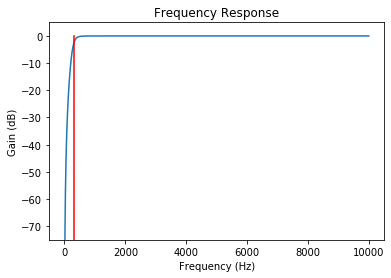

In [122]:
db = 20*np.log10(np.maximum(np.abs(h), 1e-5)) # don't worry about this, transforms h to dB unit
plt.plot(w/np.pi*fs/2, db) # first part transform w to in Hz unit
plt.ylim(-75, 5)
plt.ylabel('Gain (dB)')
plt.xlabel('Frequency (Hz)')
plt.title('Frequency Response')
plt.plot([lowcut,lowcut],[-75,0],c="red")
plt.show()

## Apply the fitler to a recording channel

We can apply our filter

In [123]:
from scipy.signal import sosfiltfilt # see https://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter
chan=3
y = sosfiltfilt(myFilter, dat[chan,:]) # we filter the raw data from channel 3 and save the results in y
print(y.shape, dat[chan,:].shape) # y has same shape as the raw data from channel 3

(20000,) (20000,)


Plot the raw and filtered signals

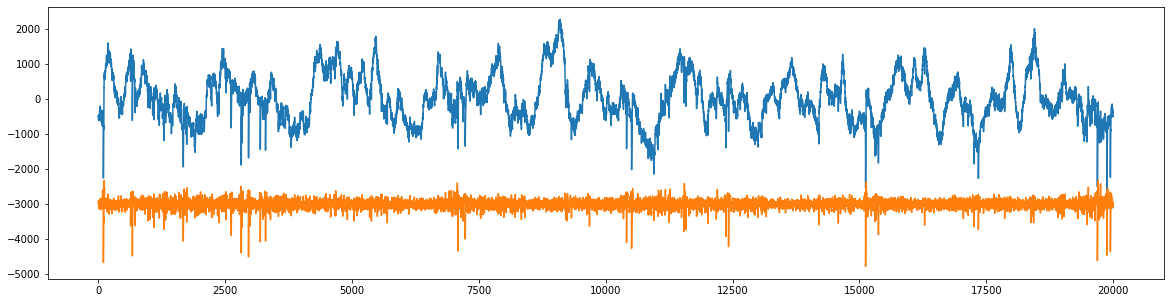

In [124]:
nSamples=20000
plt.figure(figsize=(20,5))
plt.plot(dat[chan,0:nSamples])
plt.plot(y[0:nSamples]-3000)
plt.show()

Plot fewer data points to zoom in on the raw and filtered signals. 

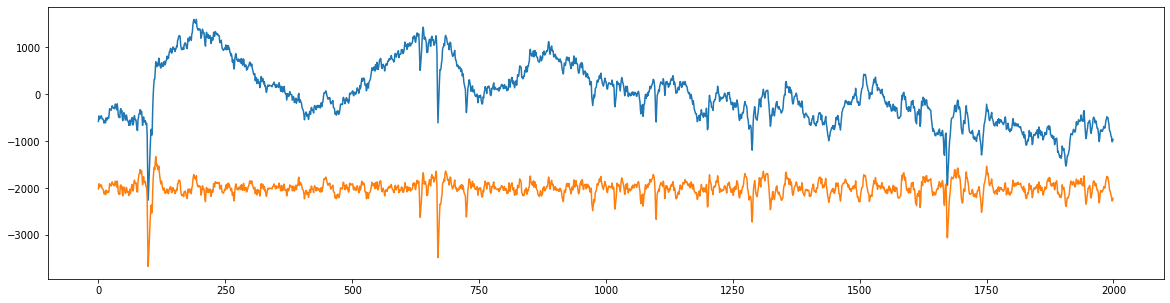

In [125]:
nSamples=2000
plt.figure(figsize=(20,5))
plt.plot(dat[chan,:0+nSamples])
plt.plot(y[:0+nSamples]-2000)

## Apply the filter to 8 recording channels

Luckily, the sosfilt() function can take 2D arrays as input, so we can filter 8 channels with one line.

In [126]:
y = sosfiltfilt(myFilter, dat) # the sosfilt() function can take a 2D array and will filter every row separately
y.shape # y now contains our 8 channels

(8, 20000)

Don't just assume that the filter was applied to all channels, plot it to be sure.

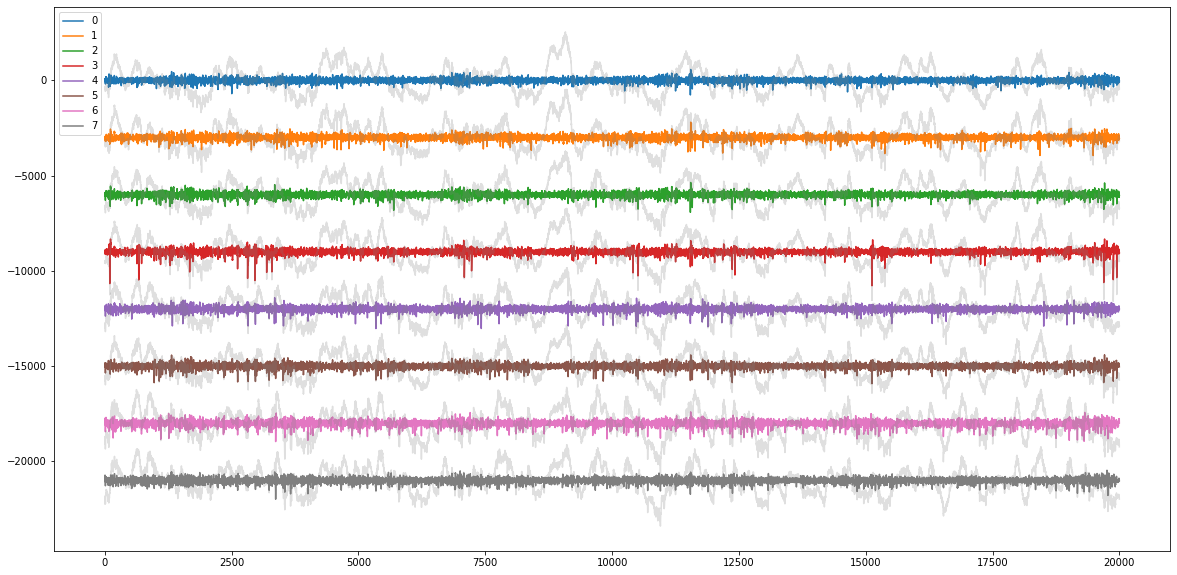

In [127]:
offset=3000 #y shift between channels
nSamples=20000
plt.figure(figsize=(20,10))

for i in range(y.shape[0]): #loop for every channel
    plt.plot(y[i,:nSamples]-i*3000,label=i) # plot the filtered data
    plt.plot(dat[i,:nSamples]-i*3000,c="gray",alpha=0.25) # plot original signal in transparent gray
plt.legend(loc="upper left")
plt.show()

***
## Detecting spikes

We have removed slow owcillations from the raw signal. We can try to identify spikes in the filtered signal.

One simple strategy is to calculate the **mean** and **standard deviation** of the filtered signal. A spike occures each time the signal reaches 5 standard deviation below the mean. This is the __spike detection threshold__.


Steps:

* Calculate mean and standard deviation
* Calculate the spike detection threshold
* Detect the events that reached the spike detection threshold

### Calculating the mean and standard deviation

We will use a single channel (chan=3) to simplify the problem.

In [128]:
chan=3 # select a channel to work with
mean=y[chan,:].mean()
std=y[chan,:].std()
print("mean:",mean)
print("std:",std)

mean: 0.040036583062989094
std: 140.0146706903993


### Calculate the spike detection threshold

In [129]:
z=5 # 5 std below the mean
threshold = mean-std*z
print("threshold:",threshold)

threshold: -700.0333168689335


Plot the data to check if this makes sense.

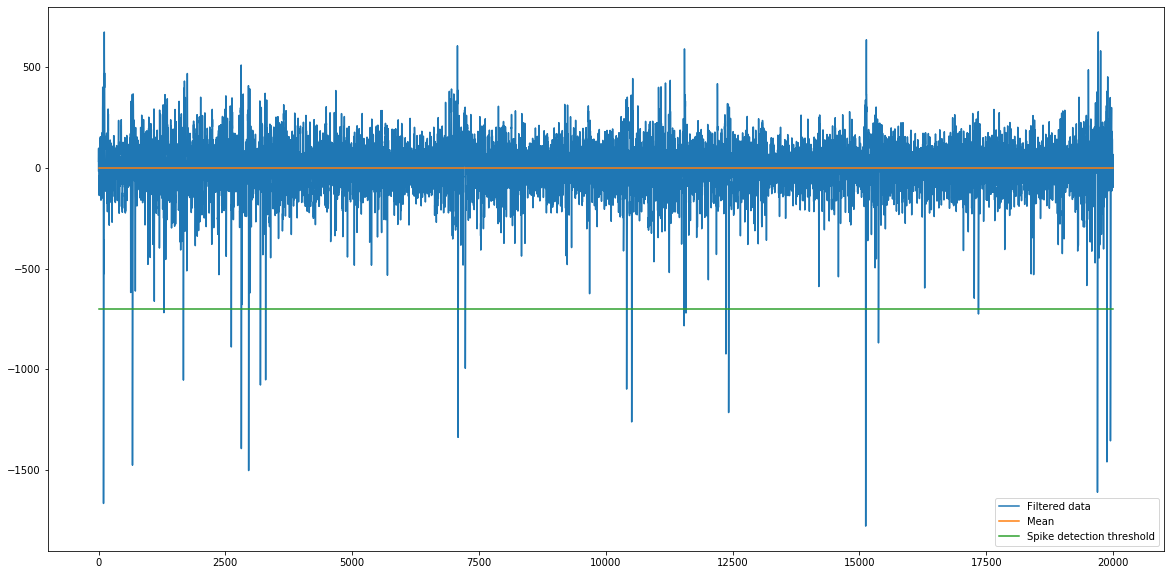

In [130]:
plt.figure(figsize=(20,10))
plt.plot(y[chan,:],label="Filtered data")
plt.plot([0,y.shape[1]],[mean,mean], label="Mean")
plt.plot([0,y.shape[1]],[threshold,threshold], label="Spike detection threshold")
plt.legend()
plt.show()

We can zoom in by plotting only the first 1000 samples.

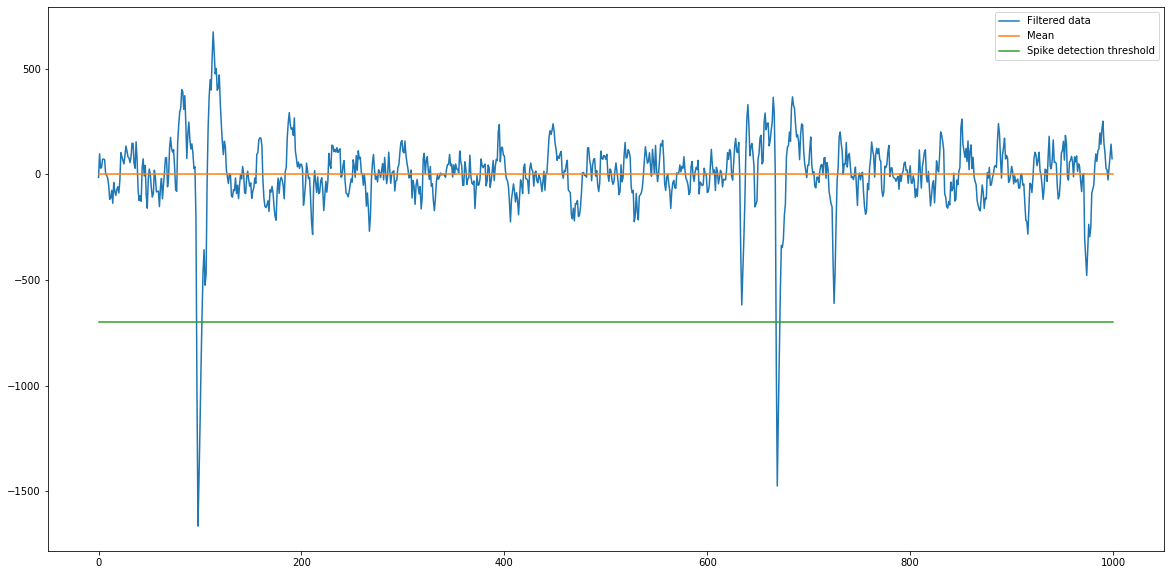

In [131]:
nSamples=1000
plt.figure(figsize=(20,10))
plt.plot(y[chan,:nSamples],label="Filtered data")
plt.plot([0,nSamples],[mean,mean],label="Mean")
plt.plot([0,nSamples],[threshold,threshold],label="Spike detection threshold")
plt.legend()
plt.show()

### Detect events that reached the spike detection threshold

We now need to find the trough of the detected spikes.

Here is one way to do it:

* Inverse the data so that the spikes are positive
* Detect the local peaks in the data using scipy.signal.find_peaks

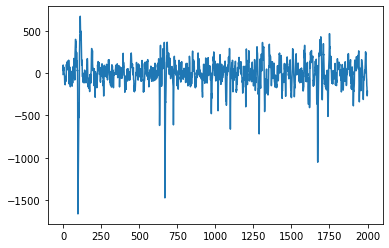

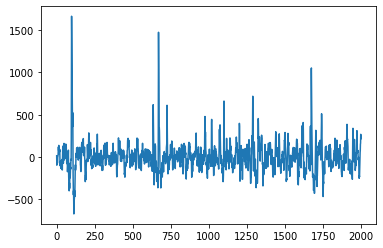

In [132]:
nSamples=2000

## important point about np.arrays
yDetect = y[chan,:].copy() # use a copy of the data to avoid destroying it during the manipulation

plt.plot(yDetect[0:nSamples])
plt.show()

# inverse the signal to get positive peaks
yDetect = 0 - yDetect # inverse 
plt.plot(yDetect[0:nSamples])
plt.show()

[`scipy.signal.find_peaks`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html) can identify the time of the peaks (spikes) for us.

In [133]:
from scipy.signal import find_peaks
spikeTimes, _ = find_peaks(x=yDetect,height=0-threshold) # the function returs 2 values, we want the first one
print("Number of detected spikes:",spikeTimes.shape[0])

Number of detected spikes: 23


We plot the filtered signal with the detected spike times. Always plot the results to make sure you get what you expect.

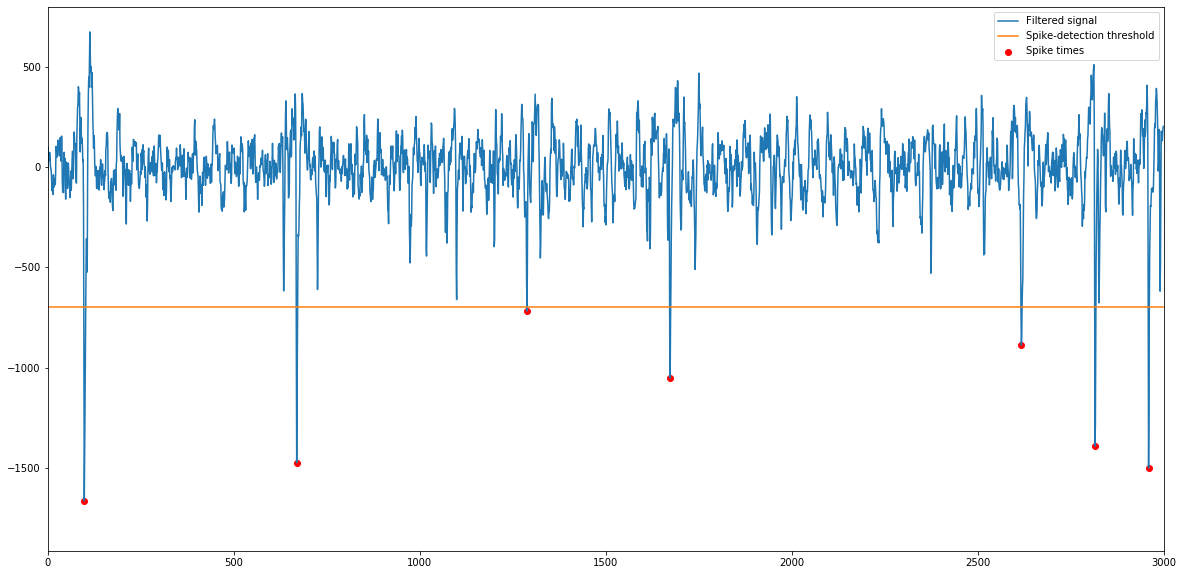

In [134]:
chan=3 # select a channel to work with
nSamples=3000
plt.figure(figsize=(20,10))
plt.plot(y[chan,:nSamples],label="Filtered signal")
plt.scatter(spikeTimes,y[chan,localPeaks],c="red",label="Spike times")
plt.plot([0,nSamples],[threshold,threshold],label="Spike-detection threshold") 
plt.xlim(0,nSamples)
plt.legend()
plt.show()

The negative spikes crossing the spike-detection threshold are identified correctly by the find_peaks() function.

### Exercises

1. Write the code that would apply our spike detection procedure to the 8 recording channels in our data? 
    a. You could try to use a `for` loops to loop across the channels. Within this loop, you can reuse the code that we used below.
    b. You could store the spike times array in a list of array.
2. Try to plot the data from all channels with their threshold and detected spikes. This would confirm that your spike detection worked.


***
## Extracting spike waveforms

We have detected 23 spikes on channel 3. In this steps, we want to extract the waveforms for these spikes from the filtered signal and store it in a new NumPy array.

<div>
<img src="../images/spike_extraction.png" width="800"/>
</div>


To do this, we need to decide on how many samples we collect per spike. 40 could be a reasonable choice. This is 1 ms before and 1 ms after the spike negative peak. 


* Axis 0: 8 channels
* Axis 1: 40 samples
* Axis 2: 23 spikes



Let's create our 3D array.

In [161]:
samplesPerSpike=40
waveforms=np.empty((dat.shape[0],samplesPerSpike,spikeTimes.shape[0]))
print("Shape of the waveforms array:",waveforms.shape)

Shape of the waveforms array: (8, 40, 23)


Extract a first spike to test our strategy.

In [162]:
st = spikeTimes[0]
print(st)
start_index=int(st-samplesPerSpike/2)
end_index=int(st+samplesPerSpike/2)
print(start_index,end_index)
waveforms[:,:,0] = y[:,start_index:end_index]

98
78 118


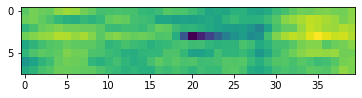

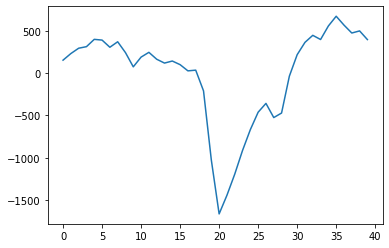

In [163]:
plt.imshow(waveforms[:,:,0])
plt.show()
plt.plot(waveforms[3,:,0])
plt.show()

Extract all 23 spikes

In [164]:
for i,st in enumerate(spikeTimes):
    start_index=int(st-samplesPerSpike/2)
    end_index=int(st+samplesPerSpike/2)
    waveforms[:,:,i] = y[:,start_index:end_index]

As always, **visualize your results**. As 3D plots are hard to visualize, we will plot a series of 2D plots.

Here are some guidlines to visualize the content of NumPy arrays of different dimensions. 

#### 1D 
* plt.plot(x)
* plt.hist(x)

#### 2D
* plt.plot(x[i,:]
* plt.hist(x[i,:]))
* plt.imshow()

#### 3D
* plt.plot(x[i,j,:])
* plt.imshow(x[i,:,:])


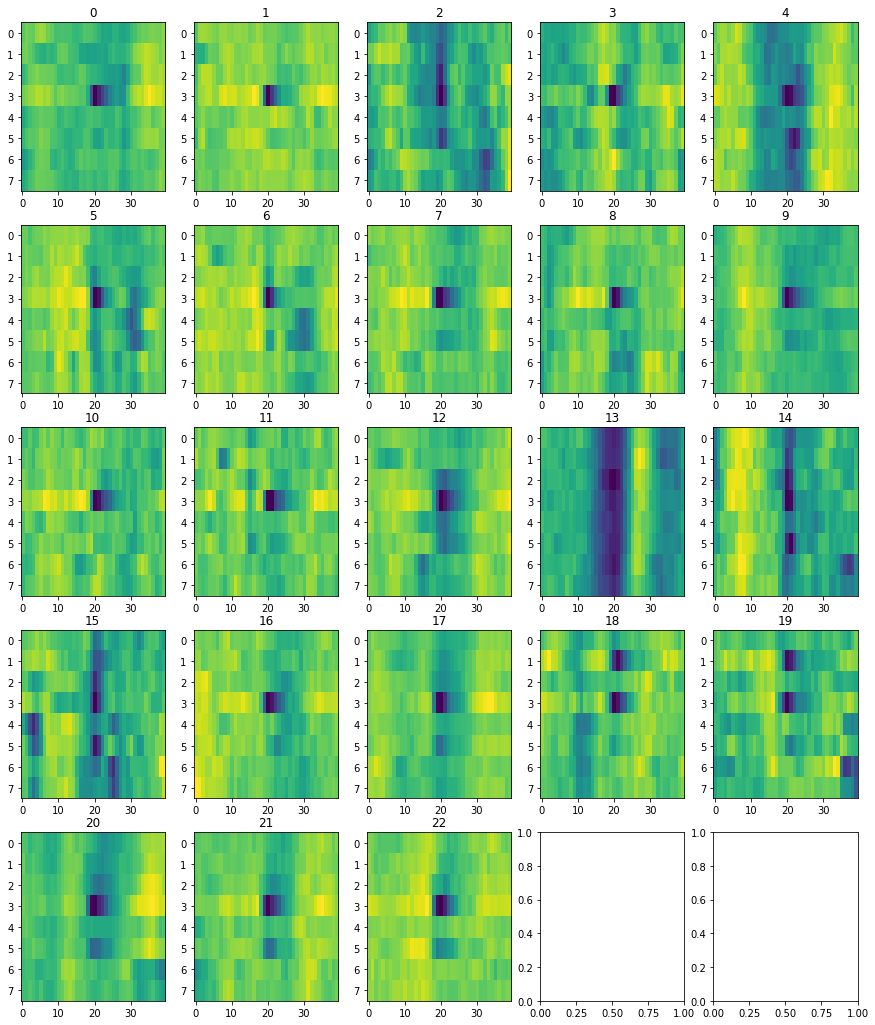

In [205]:
nrows=5
ncols=5
fig, ax = plt.subplots(5,5,figsize=(15,18))
for i in range(waveforms.shape[2]):
    #print(i,int(i/5),i%5)
    ax[int(i/5),i%5].imshow(waveforms[:,:,i],aspect="auto")
    ax[int(i/5),i%5].set_title(i)

## Discussion

* What do you see in this figure?
* Do you notice some patterns in the data?
* Do you think there are groups of spikes with similar waveforms?

***
## Dimensionality reduction

Our end goal is to cluster the spikes in groups with very similar spike waveforms (putative neurons). This can be done with different clustering algorithms. In the context of clustering, every data point of a 2D waveform is a feature of the waveform.

One problem is that we have 320 (8 channels * 40 samples) data points per spikes. If we had more than 100,000 spikes as commonly seen in the lab, the clustering algorithms would be very slow.

Our aim with dimensionality reduction is to reduce the number of features to a lower number.

The traditional way to do this is with **principal component analysis**. 

PS: There are now fancier way to do dimensionality reduction (e.g., autoencoder).

### Principal component analysis

Principal component analysis (PCA) is the process of computing the principal components and using them to perform a change of basis on the data, sometimes using only the first few principal components and ignoring the rest.

Each component is a linear combination of the features and a set of coefficients. The first component is the vector in which there is the most variance in the data.

* [wikipedia](https://en.wikipedia.org/wiki/Principal_component_analysis)
* [PCA with scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

We will use a class from the [scikit-learn](https://scikit-learn.org/stable/index.html#) package to do PCA. scikit-learn is a package to apply machine learning

In [206]:
from sklearn.decomposition import PCA
pca = PCA(n_components=15) # the number of components should be lower than number of spikes (usually not a problem!)
type(pca)

sklearn.decomposition._pca.PCA

To use PCA, we need to get a 2D array (spikes,features) from our 3D array.

In [207]:
print(waveforms.shape)
wf_fea = waveforms.transpose(2,0,1)
print(wf_fea.shape)
wf_fea = wf_fea.reshape(wf_fea.shape[0],-1)
print("dimension:",wf_fea.shape)

(8, 40, 23)
(23, 8, 40)
dimension: (23, 320)


In [208]:
pca.fit(wf_fea)

PCA(n_components=15)

[0.24404218 0.18031224 0.10778006 0.07055521 0.06272646 0.05316288
 0.04428943 0.03723758 0.02690037 0.02544084 0.02269731 0.01925999
 0.01829325 0.01561454 0.01246908]
Total explained variance:  0.9407814309534615


Text(0, 0.5, 'Explained variance')

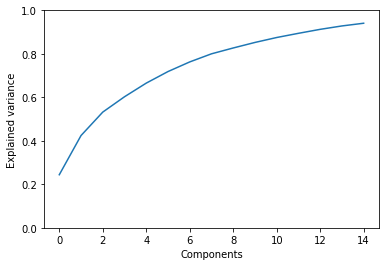

In [209]:
print(pca.explained_variance_ratio_)
print("Total explained variance: ", np.sum(pca.explained_variance_ratio_))
#
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylim(0,1)
plt.xlabel("Components")
plt.ylabel("Explained variance")

In [210]:
wf_fea_pca = pca.transform(wf_fea)
print("new dimensions:",wf_fea_pca.shape)

new dimensions: (23, 15)


We went from 320 to 15 features per spikes. 

We can print the first 2 PC of the spikes.

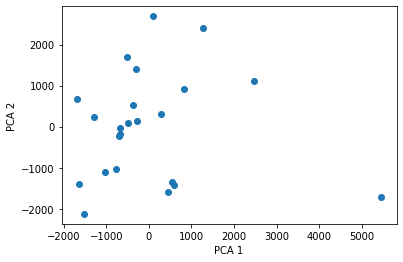

In [217]:
plt.scatter(wf_fea_pca[:,0],wf_fea_pca[:,1])
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

Was there a spike that looked very different than the other one? One spike is far away from the other ones.

In [219]:
print("PCA 1:",wf_fea_pca[:,0])
print("Spike with the largest PCA1: ", np.argmax(wf_fea_pca[:,0]))

PCA 1: [ -523.46595179 -1288.54679604   586.71017923 -1692.13139239
  2476.66123794 -1535.97373023 -1653.27282976  -484.62734658
  -670.93546824  -783.03690686 -1023.10394848  -276.96661161
   814.11602827  5461.15169515   447.77397928   551.35274036
  -668.06974059  1264.50883418   278.0933904   -692.36450862
    96.64518159  -300.82214784  -383.69588738]
Spike with the largest PCA1:  13
